# Projecting demographics onto population

For the population grids we have, project country-wise demographic information. For example, say we want to consider only population in a given age range, we want to apply the % of population in that age band to each population point.

## Method

- Summarise the 'big' demographics table.
- To do this, need to collect data for all countries. UN tables doesn't seem to have information for every country for every near so need to collect several years as squash them together. Lets take 2005-2010.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio import features


from numba import jit

import population_tools
from config import DATA_SRC, POP_DATA_SRC, HUMANS_SRC, COUNTRY_POLY_SHP

In [2]:
un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'UNdata_Export_demographics_2015.csv')
un_demographics['Country or Area Code'] = un_demographics['Country or Area Code'].apply(lambda c: c.zfill(3))
# Merge on source year
un_demographics = un_demographics.drop('Source Year', axis=1)
un_demographics = un_demographics.drop_duplicates()
un_demographics.head()

,Country or Area Code,Country or Area,Year,Area,Sex,Age,Reliability,Value,Value Footnotes
0,248,Åland Islands,2014.0,Total,Both Sexes,Total,"Final figure, complete",28791.5,1
1,248,Åland Islands,2014.0,Total,Both Sexes,0,"Final figure, complete",286.0,1
2,248,Åland Islands,2014.0,Total,Both Sexes,0 - 4,"Final figure, complete",1506.5,1
3,248,Åland Islands,2014.0,Total,Both Sexes,1,"Final figure, complete",303.5,1
4,248,Åland Islands,2014.0,Total,Both Sexes,1 - 4,"Final figure, complete",1220.5,1


In [4]:
len(un_demographics['Country or Area'].unique())

120

In [180]:
# Set index so we can first drop aspects we aren't interested in
un_all = un_demographics.set_index(['Sex', 'Area', 'Year', 'Country or Area Code',  'Age'])
un_all = un_all.loc['Both Sexes'].loc['Total'].loc[2015]

In [197]:
# Drop the country totals
un_all = un_all.drop('Total', level='Age')

In [210]:
def rows_over_age_range(country_table, lower_bound):
    
    index_pos = 0
    for i, idx in enumerate(country_table.index):
        bounds = list(map(int, idx.split('-')))
        range_start = bounds[0]
        if lower_bound <= range_start:
            index_pos = i
            break
            
    rows = country_table.index[index_pos:]
    return rows


def sum_over_age(country_table):
    country_table = country_table.reset_index().set_index('Age')

    lower_bound = 5
    upper_bound = 99

    age_range = ['{}'.format(age) for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]
    if '100+' in country_table.index:
        age_range.append('100+')
    ages = country_table.loc[age_range]
    return ages.Value.sum()
    
def fraction_over_age(country_table, lower_bound=6):
    """
    Calculate the fraction of the population over a given age
    
    For most countries, can just select each year.
    However a few countries notably japan only have data as age ranges >:(
    
    """
    country_table = country_table.reset_index().set_index('Age')

    upper_bound = 99

    age_range = [age for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]

    total_range = ['{}'.format(age) for age in range(0, 99) 
             if '{}'.format(age) in country_table.index]

    if len(age_range) == 0:
        age_range = rows_over_age_range(country_table, lower_bound)

    else:
        age_max = max(age_range)
        age_max_plus = f'{age_max+1}+'
        if age_max_plus in country_table.index:
            age_range.append(age_max_plus)
            total_range.append(age_max_plus)
    
    age_range = list(map(str, age_range))

    ages = country_table.loc[age_range]
    total = country_table['Value'].sum()
    
    try:
        return ages['Value'].sum() / total
    except:
        print(country_table)
        print(total)      
    
    
by_age = un_all.groupby(level='Country or Area Code', group_keys=True).apply(fraction_over_age)
by_age.name = 'frac_over_5'

75

In [229]:
population_file = POP_DATA_SRC / 'population_count_2000-2020.nc'

pop_data = xr.open_dataset(str(population_file))

In [214]:
gpd_countries = gpd.read_file(str(COUNTRY_POLY_SHP))

In [215]:
gpd_countries = gpd_countries.join(by_age, on='ISO_N3')

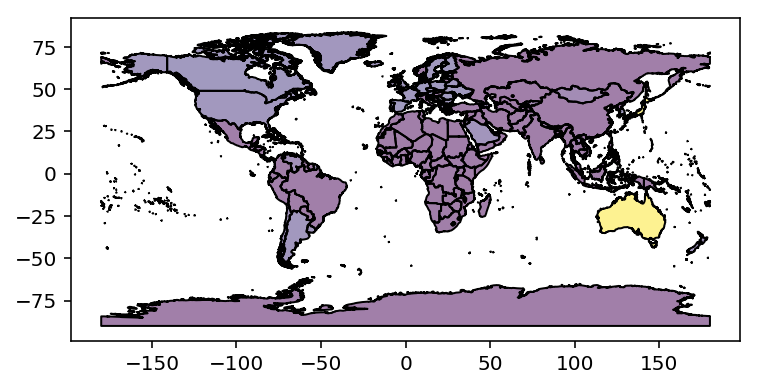

In [216]:
gpd_countries.plot(column='frac_over_5')

In [254]:
pop_affine = population_tools.get_affine(pop_data)

In [246]:
from affine import Affine

In [252]:
pop_affine = Affine(pop_affine.a, pop_affine.b, -180, pop_affine.c, pop_affine.d, pop_affine.e)

In [253]:
pop_affine

Affine(0.066666666666667124, 0.0, -180.0,
       0.0, 0.0, -0.066666666666662877)

In [257]:
gpd_countries.geometry = gpd_countries.translate(xoff=180)

In [258]:
raster = features.rasterize(
    ((r.geometry, r.frac_over_5) for _, r in gpd_countries.iterrows()),
    out_shape=pop_data.population.shape[:2], 
    transform=pop_affine
              )

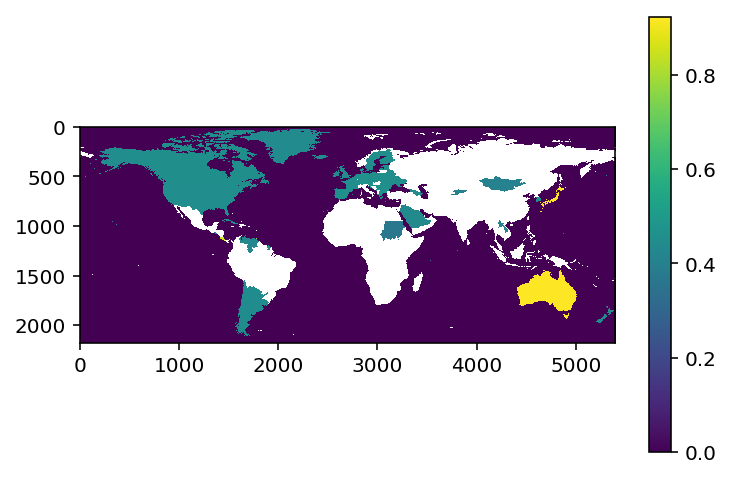

In [261]:
plt.imshow(raster, interpolation='nearest')
plt.colorbar()

In [228]:
from importlib import reload
reload(population_tools)

<module 'population_tools' from '/Users/jonathanchambers/Documents/UCL/Lancet/health-climate-exposure/population_tools.py'>

In [52]:
# Aborted attempt to index the population grid
# Looks like rasterising the countries shapes is going to work much better and be much faster
import rtree.index

lon, lat = np.meshgrid(pop_data.longitude[:10], pop_data.latitude[:10])

@jit
def build_index():
    idx = rtree.index.Index(str(DATA_SRC / 'lancet' / 'pop_file_index'))
    dims = lon.shape
    c = 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            lo = lon[i, j]
            la = lat[i, j]
            idx.insert(c, (lo, la), obj=(i, j))
            c += 1
    return idx
    